<a href="https://colab.research.google.com/github/simonfromseoul/PRM-HW/blob/main/Copy_of_PM_HW3_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework 1 — Part 3: Allocations (Christina ver)

In [ ]:

import pandas as pd, numpy as np
from pathlib import Path
from numpy.linalg import inv

DATA_PATH = Path('multi_asset_etf_data.xlsx')
df = pd.read_excel(DATA_PATH, sheet_name='excess returns')
try:
    df.iloc[:,0] = pd.to_datetime(df.iloc[:,0])
    df = df.set_index(df.columns[0])
except Exception:
    pass

returns = df.select_dtypes(include=[np.number]).dropna(how='all').sort_index()
ANN = 12

mu_month = returns.mean()
cov_month = returns.cov()
mu_ann = mu_month * ANN
cov_ann = cov_month * ANN

assets = returns.columns.tolist()
n = len(assets)
print('Assets:', assets)
print('Observations:', len(returns))

Assets: ['BWX', 'DBC', 'EEM', 'EFA', 'HYG', 'IEF', 'IYR', 'PSP', 'QAI', 'SPY', 'TIP']
Observations: 164


In [ ]:
# Calculate weight

# Equally-weighted (EW): 1/n
ones = np.ones(n)
w_ew = np.ones(n) / n

# “Risk-parity” (RP): 1/variance
vars = np.diag(cov_ann.values)
w_rp_raw = 1.0 / vars
w_rp_unit = w_rp_raw / np.sum(w_rp_raw)

# Regularized (REG): Sigma_hat = 0.5*(Sigma + Sigma_D)
Sigma = cov_ann.values
Sigma_D = np.diag(np.diag(Sigma))
Sigma_hat = 0.5 * (Sigma + Sigma_D)
w_reg_raw = np.linalg.inv(Sigma_hat).dot(mu_ann.values)
w_reg_unit = w_reg_raw / (ones.dot(w_reg_raw))

# Tangency Portfolio
w_tan_raw = np.linalg.inv(cov_ann.values).dot(mu_ann.values)
w_tan_unit = w_tan_raw / (ones.dot(w_tan_raw))

# Target mean
mu_target = 0.12

def rescale_to_target(w, mu_ann_vals, target):
    cur = w.dot(mu_ann_vals)
    if np.isclose(cur, 0):
        return w
    return w * (target / cur)

w_ew_scaled = rescale_to_target(w_ew, mu_ann.values, mu_target)
w_rp_scaled = rescale_to_target(w_rp_unit, mu_ann.values, mu_target)
w_reg_scaled = rescale_to_target(w_reg_unit, mu_ann.values, mu_target)
w_tan_scaled = rescale_to_target(w_tan_unit, mu_ann.values, mu_target)

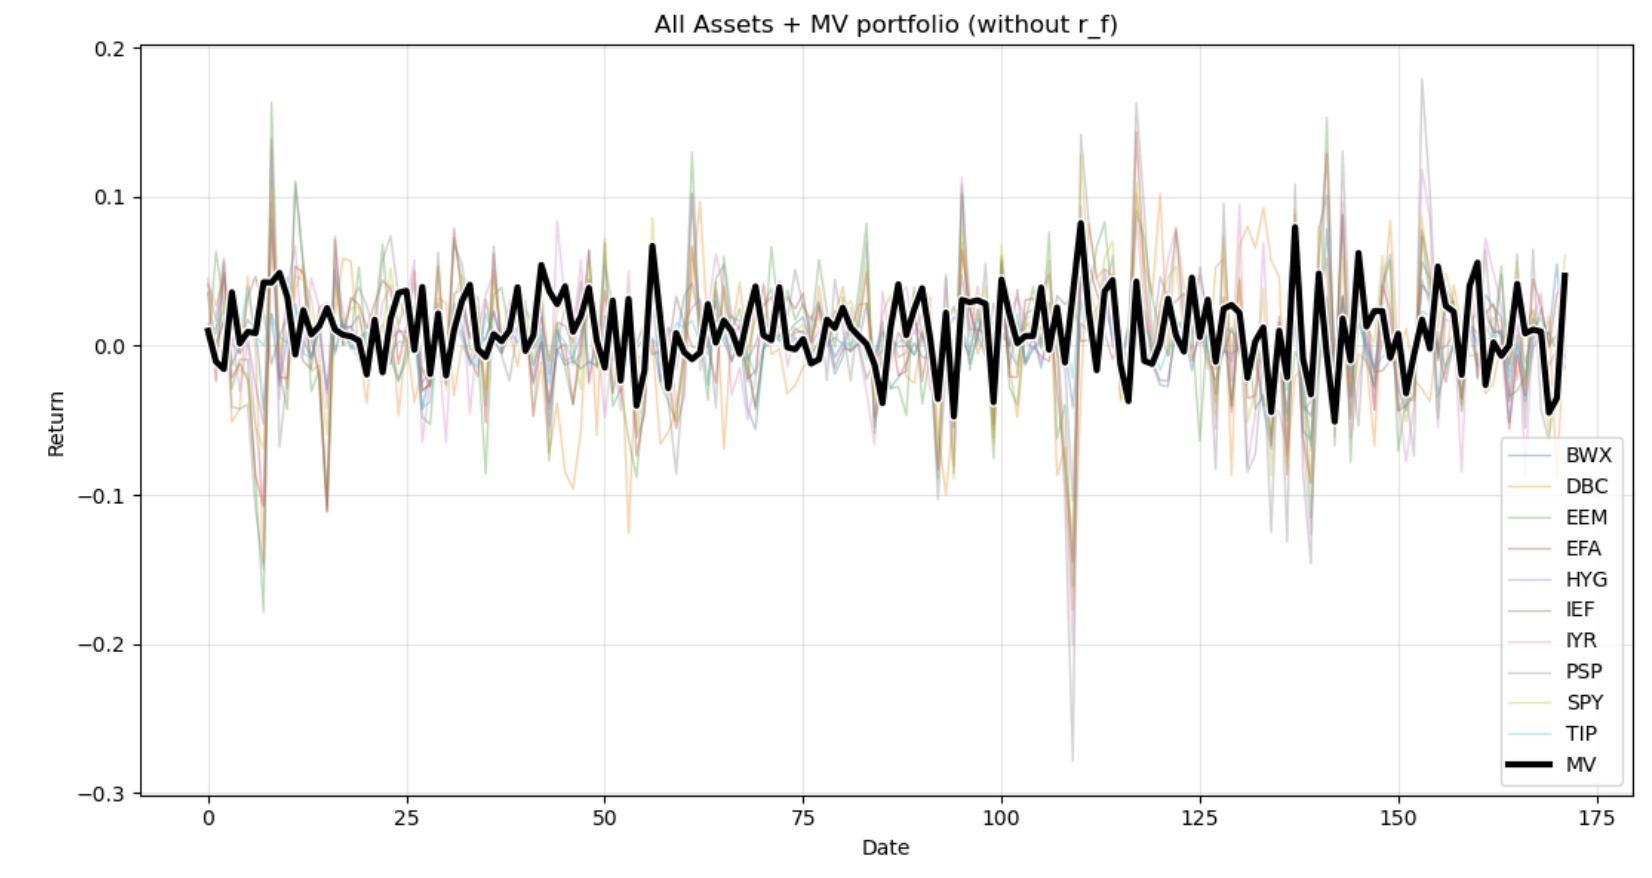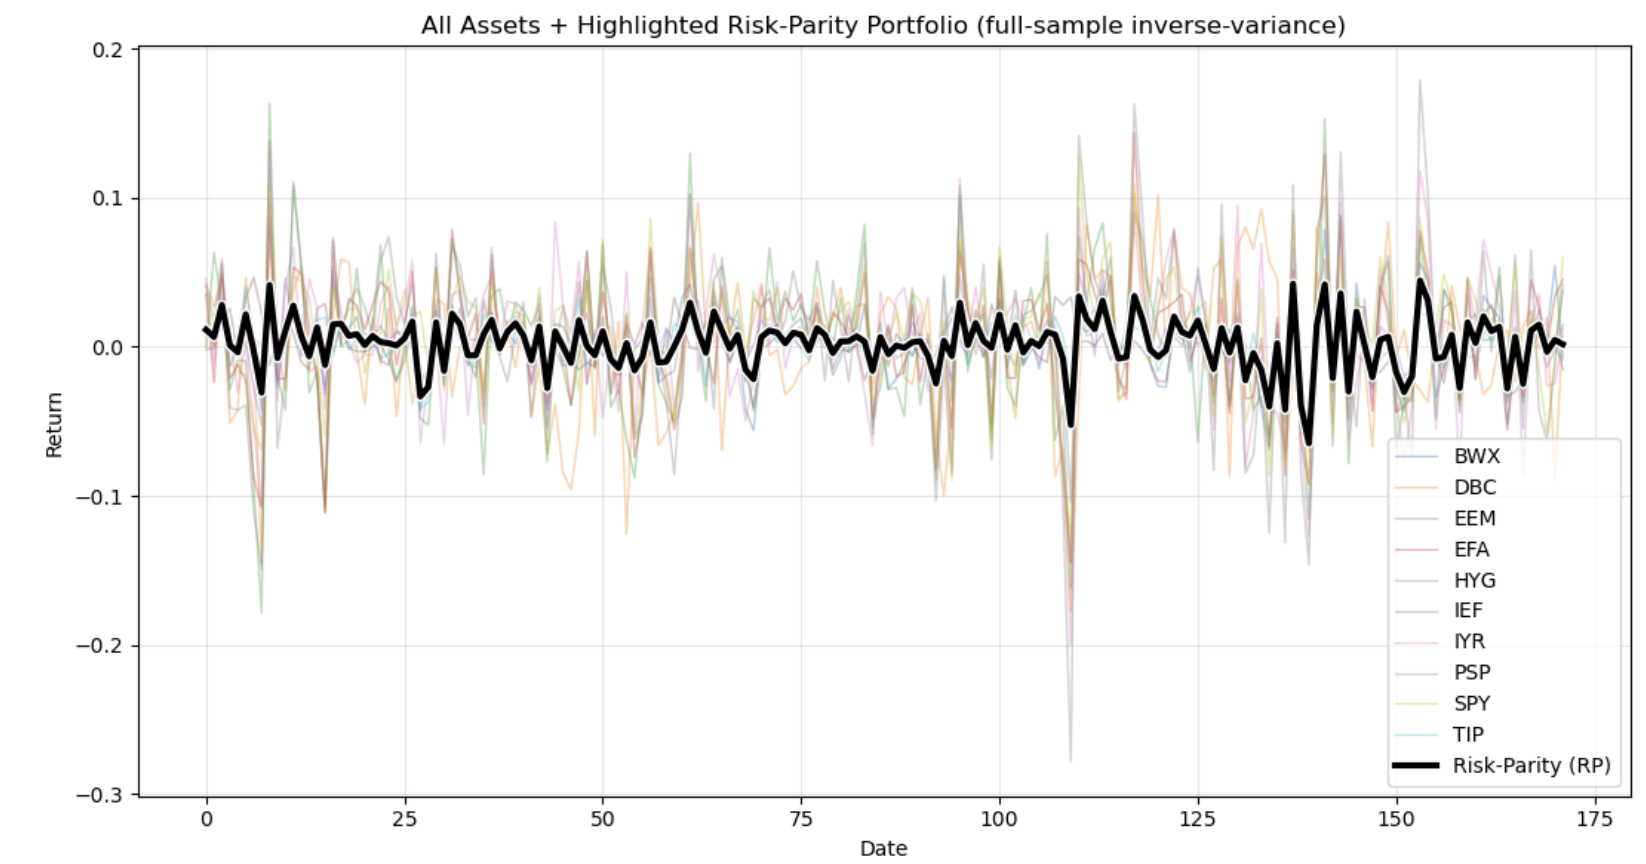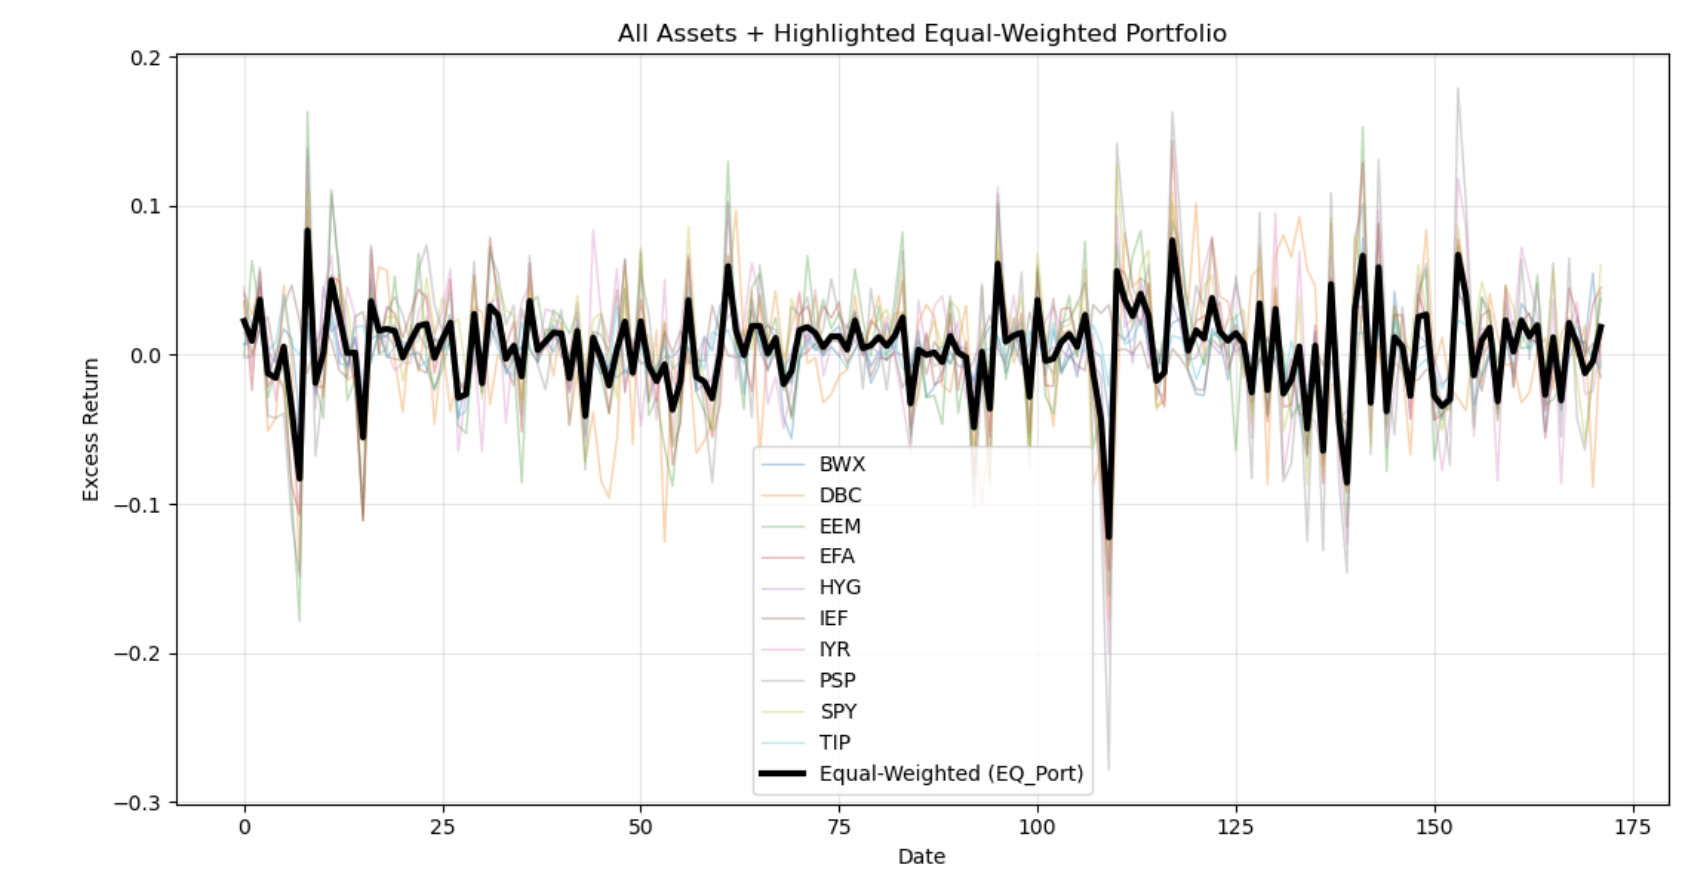

In [ ]:
# Calculate the performance of each of these portfolios over the sample

n_assets = len(returns.columns)
portfolios = {}

# Suppose the investor has a targeted mean excess return (per month) of $\mu^{*}$ = 0.01.
MU_TARGET = 0.010

# Equally-weighted (EW)
p_equal_raw = returns.dot(w_ew_scaled)
p_equal = p_equal_raw * MU_TARGET / p_equal_raw.mean()
portfolios["Equal Weights"] = p_equal

# “Risk-parity” (RP)
p_rp_raw = returns.dot(w_rp_scaled)
p_rp = p_rp_raw * MU_TARGET / p_rp_raw.mean()
portfolios["Risk Parity"] = p_rp

# Regularized (REG)
p_reg_raw = returns.dot(w_reg_scaled)
p_reg = p_reg_raw * MU_TARGET / p_reg_raw.mean()
portfolios["Regularized Portfolio"] = p_reg

# Tangency Portfolio
p_tan_raw = returns.dot(w_tan_scaled)
p_tan = p_tan_raw * MU_TARGET / p_tan_raw.mean()
portfolios["Tangency Portfolio"] = p_tan

portfolios_df = pd.DataFrame(portfolios)

portfolios_df

,Equal Weights,Risk Parity,Regularized Portfolio,Tangency Portfolio
Date,,,,
2011-02-28,0.060980,0.047690,0.024063,0.015249
2011-03-31,0.025603,0.032566,-0.011978,-0.003583
2011-04-30,0.104131,0.139159,0.002404,-0.024090
2011-05-31,-0.035098,0.002996,0.020293,0.020357
2011-06-30,-0.046328,-0.032283,-0.008892,-0.000398
...,...,...,...,...
2024-05-31,0.063925,0.077448,0.041103,0.031043
2024-06-30,0.004151,0.007010,0.031826,0.057063
2024-07-31,0.063089,0.091001,0.014307,-0.016777


In [ ]:
# Report their mean, volatility, and Sharpe ratio

def stats_from_returns(w, returns_df, ann=12):
    port = returns_df.dot(w)
    mean_ann = port.mean() * ann
    vol_ann = port.std(ddof=1) * np.sqrt(ann)
    sharpe_ann = mean_ann / vol_ann if vol_ann > 0 else np.nan
    return mean_ann, vol_ann, sharpe_ann

portfolios = {
    'Equal Weights': w_ew_scaled,
    'Risk Parity': w_rp_scaled,
    'Regularized Portfolio': w_reg_scaled,
    'Tangency Portfolio': w_tan_scaled
}

rows = []
for name, w in portfolios.items():
    mean_ann, vol_ann, sharpe_ann = stats_from_returns(w, returns, ann=ANN)
    rows.append({'Portfolio': name, 'Annualized Mean': mean_ann, 'Annualized Vol': vol_ann, 'Annualized Sharpe': sharpe_ann, 'SumWeights': w.sum()})
results = pd.DataFrame(rows).set_index('Portfolio')
weights_df = pd.DataFrame(portfolios, index=assets)

print("Report Annualized Mean,Volatility, and Sharpe ratio:")
display(results.round(6))

print("Report scaled weight of four allocation methods:")
display(weights_df)

Report Annualized Mean,Volatility, and Sharpe ratio:


,Annualized Mean,Annualized Vol,Annualized Sharpe,SumWeights
Portfolio,,,,
Equal Weights,0.12,0.291527,0.411625,2.987328
Risk Parity,0.12,0.309515,0.387703,5.507806
Regularized Portfolio,0.12,0.102604,1.169541,0.789321
Tangency Portfolio,0.12,0.074765,1.605037,-0.227585


Report scaled weight of four allocation methods:


,Equal Weights,Risk Parity,Regularized Portfolio,Tangency Portfolio
BWX,0.271575,0.522879,-0.675374,-0.621364
DBC,0.271575,0.122905,-0.136195,0.025317
EEM,0.271575,0.107717,-0.066165,0.140124
EFA,0.271575,0.150554,0.037302,-0.120777
HYG,0.271575,0.583857,0.316781,0.189482
IEF,0.271575,0.873276,0.393506,1.065661
IYR,0.271575,0.121273,0.080277,-0.199617
PSP,0.271575,0.075284,0.049547,-0.063041
QAI,0.271575,1.452202,-0.156500,-1.643297
SPY,0.271575,0.170397,0.623712,1.116095


## COMPARISON
### Return: The four methods yield the same annualized return, indicating no difference in their return projections.
### Volatility: Tangency < Regularized << Equal Weights < Risk Parity
### Sharpe: Tangency > Regularized >> Equal Weights > Risk Parity